In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../..'))) # access sibling directories
sys.path.append("C:\\Users\\lasse\\Documents\\GitHub\\BayesFlow")

from src.python.settings import summary_meta_validation, probability_meta_validation
from src.python.networks import HierarchicalInvariantNetwork, ModelProbabilityNetwork
from src.python.models import HierarchicalNormalSimulator, MainSimulator
from src.python.losses import softmax_loss
from src.python.helpers import n_clust_obs_f_f, get_repeated_predictions, get_bootstrapped_predictions, get_preds_and_bfs
from src.python.visualization import perf_tester, plot_calibration_curve_repetition_uncertainty

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.optimizers import Adam
from functools import partial
from time import perf_counter
from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt

from bayesflow.trainers import ModelComparisonTrainer
from bayesflow.amortizers import MultiModelAmortizer 

In [2]:
# Hack to correctly set facecolor to white
# matplotlib 3.5 only sets facecolor if a plot was already created 
_ = plt.figure()
plt.rcParams['figure.facecolor'] = 'w'

<Figure size 432x288 with 0 Axes>

# Model formulation

$$
\begin{align}
x_n &\sim \mathcal{N}(\theta_l, \sigma^2) \text{ for } n=1,...,N \\
\theta_l &\sim \mathcal{N}(\mu, \tau^2) \text{ for } l=1,...,L\\
\sigma^2 &\sim Half-Normal(\sigma_s)\\
\mu &\sim \mathcal{N}(\mu_0, \tau_0)\\
\tau^2 &\sim Half-Normal(\sigma_t)\\
\end{align}
$$

$$
\begin{align}
&\text{Null Model }M_0 \text{: } \mu=0\\
&\text{Alternative Model }M_1 \text{: } \mu \text{ allowed to differ from 0} \\
\end{align}
$$

# Set up networks

In [3]:
summary_net = HierarchicalInvariantNetwork(summary_meta_validation)
probability_net = ModelProbabilityNetwork(probability_meta_validation)

amortizer = MultiModelAmortizer(probability_net, summary_net)

simulator = MainSimulator(HierarchicalNormalSimulator())

In [4]:
# Training steps
epochs=10 
iterations_per_epoch=1000

# Cosine decaying learning rate
initial_lr = 0.0005
decay_steps = epochs*iterations_per_epoch
alpha = 0
lr_schedule = CosineDecay(
    initial_lr, decay_steps, alpha=alpha
    )

# Checkpoint path for loading pretrained network and saving the final network
checkpoint_path = 'C:\\Users\\lasse\\Documents\\hierarchical model comparison project\\checkpoints\\01_calibration_validation\\checkpoints_fixed'
checkpoint_path = os.path.join(os.getcwd(), trial_folder)

trainer = ModelComparisonTrainer(
    network=amortizer, 
    generative_model=simulator, 
    loss=partial(softmax_loss),
    optimizer=partial(Adam, lr_schedule),
    checkpoint_path=checkpoint_path,
    skip_checks=True,
    )

Initializing networks from scratch.


# Train & validate

In [5]:
training_time_start = perf_counter()
losses = trainer.train_online(epochs=epochs, iterations_per_epoch=iterations_per_epoch, batch_size=32, n_obs=n_clust_obs_f_f)
training_time_stop = perf_counter()

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]

ECE = 0.036


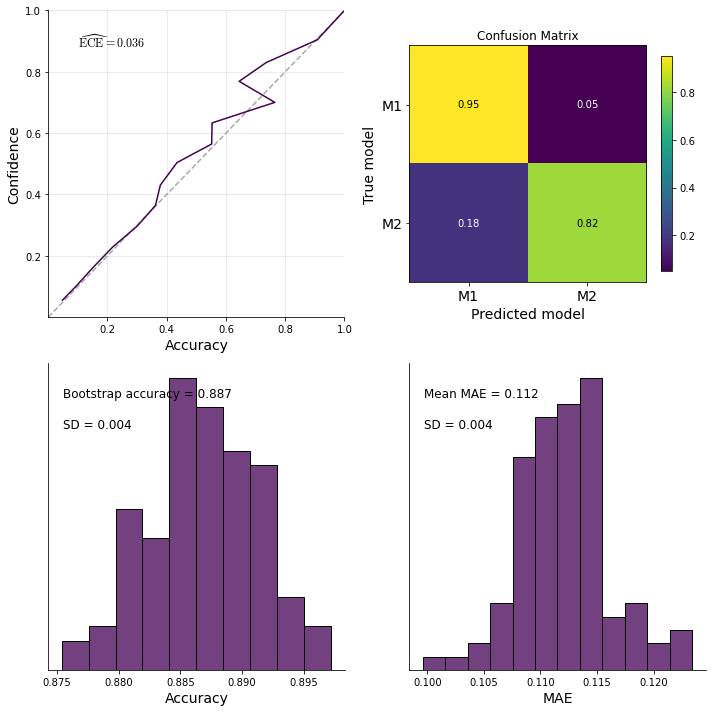

In [6]:
# Validation
n_val = 5000
m_val, _, x_val = simulator(n_val, n_clust_obs_f_f())
val_data = {'X' : x_val, 'm' : m_val}

perf_tester(probability_net, summary_net, val_data, n_cal_bins=15)

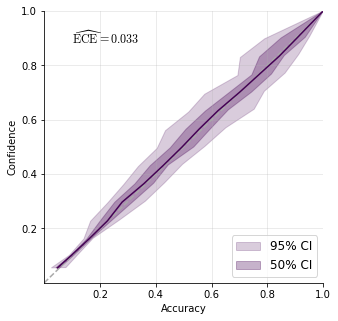

In [7]:
# Plot calibration with repetition uncertainty
n_repetitions = 25

fig, ax = plt.subplots(1, 1, figsize=(5,5))
m_true_r, m_soft_r = get_repeated_predictions(probability_net, summary_net, partial(simulator, batch_size=n_val, n_obs=n_clust_obs_f_f(50, 50)), 
                                          n_models=2, n_repetitions=n_repetitions)

plot_calibration_curve_repetition_uncertainty(m_true_r[:,:,1], m_soft_r[:,:,1], narrow_ci=[0.25, 0.75], wide_ci=[0.025, 0.975], n_bins=15, ax=ax, 
                                    xlabel=True, ylabel=True, title=None, show_ece=True, show_legend=True)

fig.savefig('calibration_fixed.pdf', dpi=300, bbox_inches='tight')

ECE = 0.022


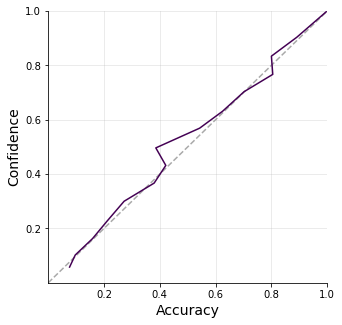

In [15]:
# Plot single cal curve
from src.python.visualization import plot_calibration_curve
fig, ax = plt.subplots(figsize=(5,5))

m_val, _, x_val = simulator(n_val, n_clust_obs_f_f())
val_data = {'X' : x_val, 'm' : m_val}

# Compute model predictions in chunks so GPU memory does not blow-up
m_soft = tf.concat([probability_net.predict(summary_net(x_chunk))['m_probs'][:, 1] for x_chunk in tf.split(val_data['X'], 20)], axis=0).numpy()
m_hard = (m_soft > 0.5).astype(np.int32)
m_true = val_data['m'][:, 1]
plot_calibration_curve(m_true, m_soft, n_bins=15, ax=ax, show_ece=False)

# Save
plt.savefig('calibration_fixed.png', dpi=300, bbox_inches='tight')

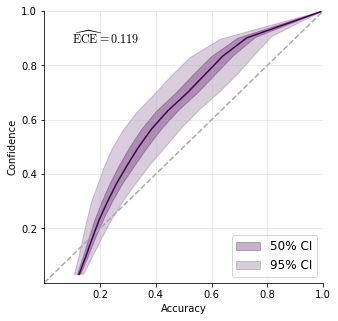

In [7]:
# Calibration curve with uncertainty

# Get Alphas
alphas = tf.concat([probability_net(summary_net(x_chunk)) for x_chunk in tf.split(val_data['X'], 500)], axis=0).numpy()

# Sample from dirichlet
n_samples = 10000
n_datasets = alphas.shape[0]
pm_samples = np.stack([np.random.dirichlet(alphas[n, :], size=n_samples) for n in range(n_datasets)], axis=0)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
narrow_ci = [0.25, 0.75]
wide_ci = [0.025, 0.975]

m_true = val_data['m'][:, 1]
pm_samples_model = pm_samples[:, :, 1]
plot_calibration_curve_uncertainty(m_true, pm_samples_model, narrow_ci=narrow_ci, wide_ci=wide_ci, n_bins=15, ax=ax)

# Save
#plt.savefig('calibration_fixed.png', dpi=300, bbox_inches='tight')

In [8]:
# Calculate calibration bins manually for each sample

# bins for sampled cal curves
from sklearn.calibration import calibration_curve
n_bins=15

# Get bins & ECE for each sample from the learned dirichlet distribution
probs_true = np.zeros((n_samples, n_bins))
probs_pred = np.zeros((n_samples, n_bins))

for n in range(n_samples):
    m_soft = pm_samples_model[:, n]
    probs_true[n, :], probs_pred[n, :] = calibration_curve(m_true, m_soft, n_bins=n_bins)
cal_err = np.mean(np.abs(probs_true - probs_pred))

(array([   6.,   67.,  392., 1350., 2599., 2987., 1799.,  651.,  135.,
          14.]),
 array([0.09029839, 0.09590304, 0.10150769, 0.10711234, 0.11271698,
        0.11832163, 0.12392628, 0.12953093, 0.13513557, 0.14074022,
        0.14634487]),
 <BarContainer object of 10 artists>)

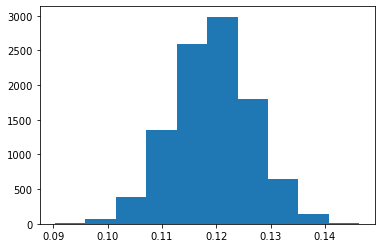

In [9]:
# ECE distribution over samples
plt.hist(np.mean(np.abs(probs_true - probs_pred), axis=1))

## Plot PMPs (dirichlet mean) against sampled PMPs

In [10]:
# Get PMPs (mean of dirichlet)
alphas0 = np.sum(alphas, axis=1, keepdims=True)
means = alphas / alphas0

# Filter for probabilities for m2
means_m2 = means[:,1]
pm_samples_m2 = pm_samples[:,:,1]

# Get standard deviations of the dirichlet
vars = alphas * (alphas0 - alphas) / (alphas0 * alphas0 * (alphas0 + 1))
stds = np.sqrt(vars)

In [11]:
# Sort by PMPs
means_m2_indices = means_m2.argsort()
sorted_means_m2 = means_m2[means_m2_indices]
sorted_samples_m2 = pm_samples_m2[means_m2_indices, :]

# Get quantiles of samples
lower_bound, upper_bound = np.quantile(sorted_samples_m2, q=[0.025, 0.975], axis=1)

# Get median
sample_median = np.squeeze(np.quantile(sorted_samples_m2, q=[0.5], axis=1))

# Get mean
sample_mean = np.mean(sorted_samples_m2, axis=1)

### Plot PMPs sorted separately

In [12]:
# Analytical mean +/- 1 std
means_plus_stds = means_m2 + stds[:, 1]
means_minus_stds = means_m2 - stds[:, 1]

# Sorted by analytical mean
means_plus_stds_sorted = (means_m2 + stds[:, 1])[means_m2_indices]
means_minus_stds_sorted = (means_m2 - stds[:, 1])[means_m2_indices]

Text(0.5, 1.0, 'Samples sorted separately')

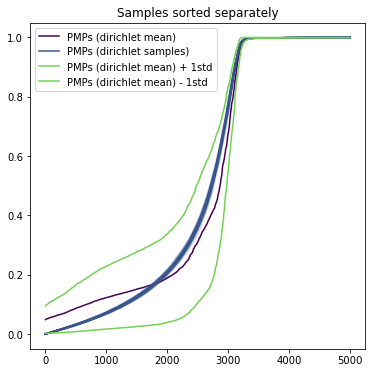

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
x_axis = np.linspace(1,means_m2.shape[0], num=means_m2.shape[0])

# Plot dirichlet mean
ax.plot(x_axis, np.sort(means_m2), color='#440154FF', label='PMPs (dirichlet mean)')

# Plot single samples
# for i in range(pm_samples_m2.shape[1]):
for i in range(100):
    ax.plot(x_axis, np.sort(pm_samples_m2[:,i]), color='#39568CFF', alpha=0.1)
ax.plot([], [], color='#39568CFF', label='PMPs (dirichlet samples)') # only add one line to legend

# Plot dirichlet mean +/- stds
ax.plot(x_axis, np.sort(means_plus_stds), color='#73D055FF', label='PMPs (dirichlet mean) + 1std')
ax.plot(x_axis, np.sort(means_minus_stds), color='#73D055FF', label='PMPs (dirichlet mean) - 1std')

ax.legend()
ax.set_title('Samples sorted separately')

In [17]:
np.mean(pm_samples_m2, axis=1).shape

(5000,)

Text(0.5, 1.0, 'Samples sorted separately')

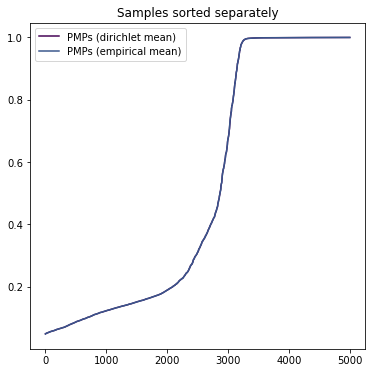

In [18]:
# Alphas instead of PMPs
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
x_axis = np.linspace(1,means_m2.shape[0], num=means_m2.shape[0])

# Plot analytical mean
ax.plot(x_axis, np.sort(means_m2), color='#440154FF', label='PMPs (dirichlet mean)')

# Plot empirical mean
ax.plot(x_axis, np.sort(np.mean(pm_samples_m2, axis=1)), color='#39568CFF', label='PMPs (empirical mean)')

ax.legend()
ax.set_title('Samples sorted separately')

### Plot PMPs sorted by PMPs (dirichlet mean)

Text(0.5, 1.0, 'Samples sorted by analytical mean')

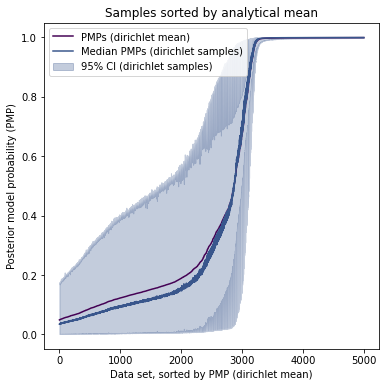

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
x_axis = np.linspace(1,means_m2.shape[0], num=means_m2.shape[0])
# ax.plot(x_axis, means_plus_stds_sorted, color='#73D055FF', label='PMPs (dirichlet mean) + 1std')
# ax.plot(x_axis, means_minus_stds_sorted, color='#73D055FF', label='PMPs (dirichlet mean) - 1std')
ax.plot(x_axis, sorted_means_m2, color='#440154FF', label='PMPs (dirichlet mean)')
ax.plot(x_axis, sample_median, color='#39568CFF', label='Median PMPs (dirichlet samples)')
# ax.plot(x_axis, sample_mean, color='#1F968BFF', label='Mean PMPs (dirichlet samples)')
ax.fill_between(x_axis, lower_bound, upper_bound, color='#39568CFF', alpha=0.3, label='95% CI (dirichlet samples)')
ax.set_xlabel('Data set, sorted by PMP (dirichlet mean)')
ax.set_ylabel('Posterior model probability (PMP)')
ax.legend()
ax.set_title('Samples sorted by analytical mean')

### Plot calibration curves with analytical stds

In [93]:
predictions = probability_net.predict(summary_net(val_data['X']))
probs = predictions['m_probs']

In [94]:
# +/- vars
probs_plus_var = predictions['m_probs'] + predictions['m_var']
probs_minus_var = predictions['m_probs'] - predictions['m_var']

# +/- stds
probs_plus_stds = predictions['m_probs'] + np.sqrt(predictions['m_var'])
probs_minus_stds = predictions['m_probs'] - np.sqrt(predictions['m_var'])

In [114]:
# Plot calibration curve
m_true = val_data['m'][:, 1]
prob_true, prob_pred = calibration_curve(m_true, probs[:, 1], n_bins=15)
prob_true_plus_var, prob_pred_plus_var = calibration_curve(m_true, probs_plus_var[:, 1], n_bins=15)
prob_true_minus_var, prob_pred_minus_var = calibration_curve(m_true, probs_minus_var[:, 1], n_bins=15)
prob_true_plus_stds, prob_pred_plus_stds = calibration_curve(m_true, probs_plus_stds[:, 1], n_bins=15)
prob_true_minus_stds, prob_pred_minus_stds = calibration_curve(m_true, probs_minus_stds[:, 1], n_bins=15)

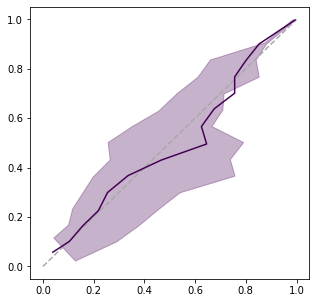

In [115]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot((0,1), (0,1), '--', color='darkgrey')
ax.plot(prob_true, prob_pred, color='#440154FF', label='PMPs (dirichlet mean)')
# ax.fill(np.append(prob_true_plus_var, prob_true_minus_var[::-1]),
#         np.append(prob_pred_plus_var, prob_pred_minus_var[::-1]),
#         color='#440154FF', alpha=0.3, label='+/- 1var')
ax.fill(np.append(prob_true_plus_stds, prob_true_minus_stds[::-1]),
        np.append(prob_pred_plus_stds, prob_pred_minus_stds[::-1]),
        color='#440154FF', alpha=0.3, label='+/- 1var')

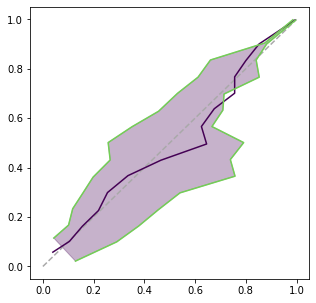

In [116]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot((0,1), (0,1), '--', color='darkgrey')
ax.plot(prob_true, prob_pred, color='#440154FF', label='PMPs (dirichlet mean)')
# ax.fill(np.append(prob_true_plus_var, prob_true_minus_var[::-1]),
#         np.append(prob_pred_plus_var, prob_pred_minus_var[::-1]),
#         color='#440154FF', alpha=0.3, label='+/- 1var')
ax.fill(np.append(prob_true_minus_stds, prob_true_plus_stds[::-1]),
        np.append(prob_pred_minus_stds, prob_pred_plus_stds[::-1]),
        color='#440154FF', alpha=0.3, label='+/- 1var')
ax.plot(prob_true_minus_stds, prob_pred_minus_stds, color='#73D055FF', label='PMPs (dirichlet mean)')
ax.plot(prob_true_plus_stds, prob_pred_plus_stds, color='#73D055FF', label='PMPs (dirichlet mean)')

In [14]:
# Save training meta-information for bridge sampling comparison?
save_training_vars = False

if save_training_vars:
    folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'data', '01_calibration_validation', '01_fixed')

    np.save(os.path.join(folder, 'training_time_start'), training_time_start, allow_pickle=True)
    np.save(os.path.join(folder, 'training_time_stop'), training_time_stop, allow_pickle=True)
    np.save(os.path.join(folder, 'losses'), losses, allow_pickle=True)

# Calculate Bayes factors for bridge sampling comparison

In [2]:
# Import training meta-information? (if network was loaded from checkpoint)
import_training_vars = True

if import_training_vars:
    folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'data', '01_calibration_validation', '01_fixed')

    training_time_start = np.load(os.path.join(folder, 'training_time_start.npy'), allow_pickle=True)
    training_time_stop = np.load(os.path.join(folder, 'training_time_stop.npy'), allow_pickle=True)
    losses = np.load(os.path.join(folder, 'losses.npy'), allow_pickle=True).item()

In [9]:
# Import test data
val_folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'data', '02_bridge_sampling_comparison', 'nested_models')
data_filename = "test_data.npy"
test_data = np.load(os.path.join(val_folder, data_filename), allow_pickle=True).item()

In [10]:
# Get NN predictions
comparison_results = get_preds_and_bfs(probability_net, summary_net, test_data, training_time_start, training_time_stop, losses)
comparison_results.head(5)

,dataset,true_model,m0_prob,m1_prob,selected_model,bayes_factor,training_time,inference_time,final_epoch_loss
0,1,0,0.830225,0.169775,0,0.204492,745.100906,0.002514,0.287687
1,2,0,0.880637,0.119363,0,0.135542,745.100906,0.002514,0.287687
2,3,0,0.882400,0.117600,0,0.133273,745.100906,0.002514,0.287687
3,4,1,0.000001,0.999999,1,838859.800000,745.100906,0.002514,0.287687
4,5,0,0.883319,0.116681,0,0.132094,745.100906,0.002514,0.287687


In [12]:
# Export results
local_timezone = datetime.now(timezone(timedelta(0))).astimezone().tzinfo
filename = pd.Timestamp.today(tz=local_timezone).strftime('%Y_%m_%d_BF_NN_fixed')
comparison_folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'data', '02_bridge_sampling_comparison', 'nested_models')

comparison_results.to_csv(os.path.join(comparison_folder, filename), index = False)